In [19]:
import pandas as pd
import utils
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
tracks = utils.load('../data/fma_metadata/tracks.csv')
features = utils.load('../data/fma_metadata/features.csv')

In [3]:
type(tracks), type(features)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [4]:
tracks.columns

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          

In [5]:
smol_tracks = tracks.loc[tracks['set']['subset'] == 'small']

In [6]:
smol_tracks.shape

(8000, 52)

In [7]:
smol_tracks.head()

album                                                           \
         comments        date_created date_released engineer favorites  id   
track_id                                                                     
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4   1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4   1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4   6   
140             1 2008-11-26 01:49:59    2007-05-22      NaN         1  61   
141             0 2008-11-26 01:49:57    2009-01-16      NaN         1  60   

                                                                     \
                                                information listens   
track_id                                                              
2                                                   <p></p>    6073   
5                                                   <p></p>    6073   
10                                                      NaN   47632   
140       <p>Alec K. Redfearn &amp; The Eyesores: Ellen ...    1300   
141       <p>A full ensamble of strings, drums, electron...    1304   

                                               ...       track           \
                                producer tags  ... information interest   
track_id                                       ...                        
2                                    NaN   []  ...         NaN     4656   
5                                    NaN   []  ...         NaN     1933   
10                                   NaN   []  ...         NaN    54881   
140       Alec K. Refearn, Rob Pemberton   []  ...         NaN     1593   
141                                  NaN   []  ...         NaN      839   

                                                                           \
         language_code                                            license   
track_id                                                                    
2                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
5                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
10                  en  Attribution-NonCommercial-NoDerivatives (aka M...   
140                 en  Attribution-Noncommercial-No Derivative Works ...   
141                 en  Attribution-Noncommercial-No Derivative Works ...   

                                                                     
         listens lyricist number publisher tags               title  
track_id                                                             
2           1293      NaN      3       NaN   []                Food  
5           1151      NaN      6       NaN   []          This World  
10         50135      NaN      1       NaN   []             Freeway  
140         1299      NaN      2       NaN   []  Queen Of The Wires  
141          725      NaN      4       NaN   []                Ohio  

[5 rows x 52 columns]

In [8]:
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  

[5 rows x 518 columns]

In [49]:
smol_tracks.merge(features, left_index=True, right_index=True)

C:\Users\098uy\anaconda3\envs\audio_project\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,3 on the right)
  warnings.warn(msg, UserWarning)


ValueError: Length of names must match number of levels in MultiIndex.

In [9]:
y, sr = librosa.load('../data/fma_small/065/065488.mp3')

C:\Users\098uy\anaconda3\envs\audio_project\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [13]:
len(y), 22050 * 30

(661257, 661500)

Librosa has a default sampling rate of 22,050 hertz. Audio track is ~30s long.

In [14]:
y

array([ 1.7501167e-09, -2.3466482e-09,  3.0153853e-09, ...,
       -5.0869823e-02, -1.7638340e-03,  0.0000000e+00], dtype=float32)

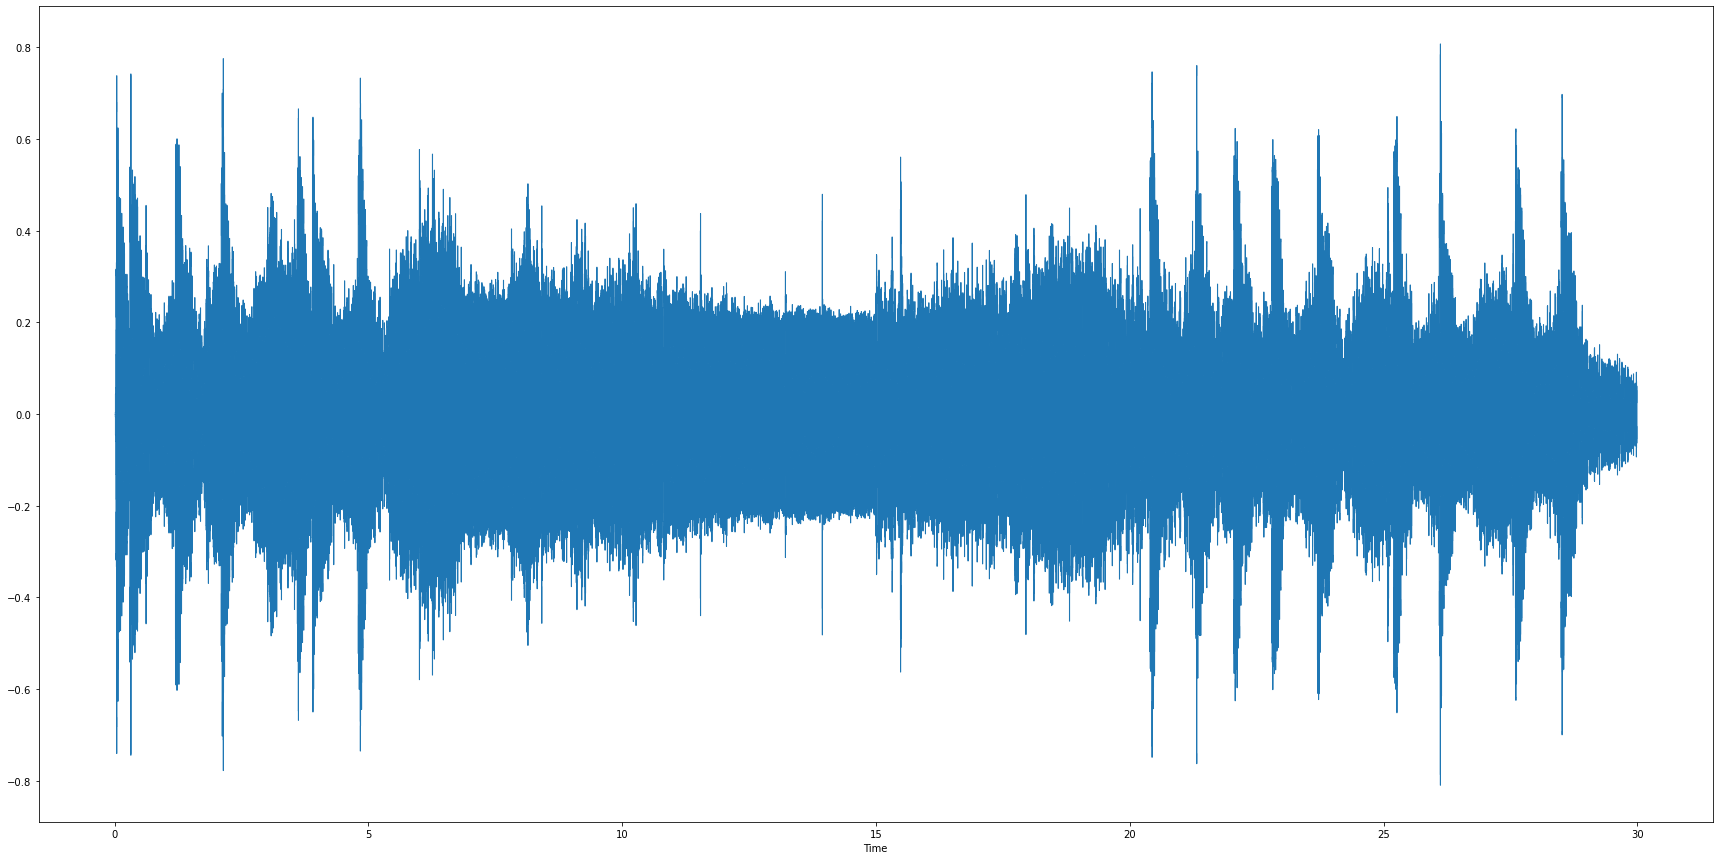

In [26]:
fig = plt.figure(figsize = (30, 15))
librosa.display.waveshow(y);

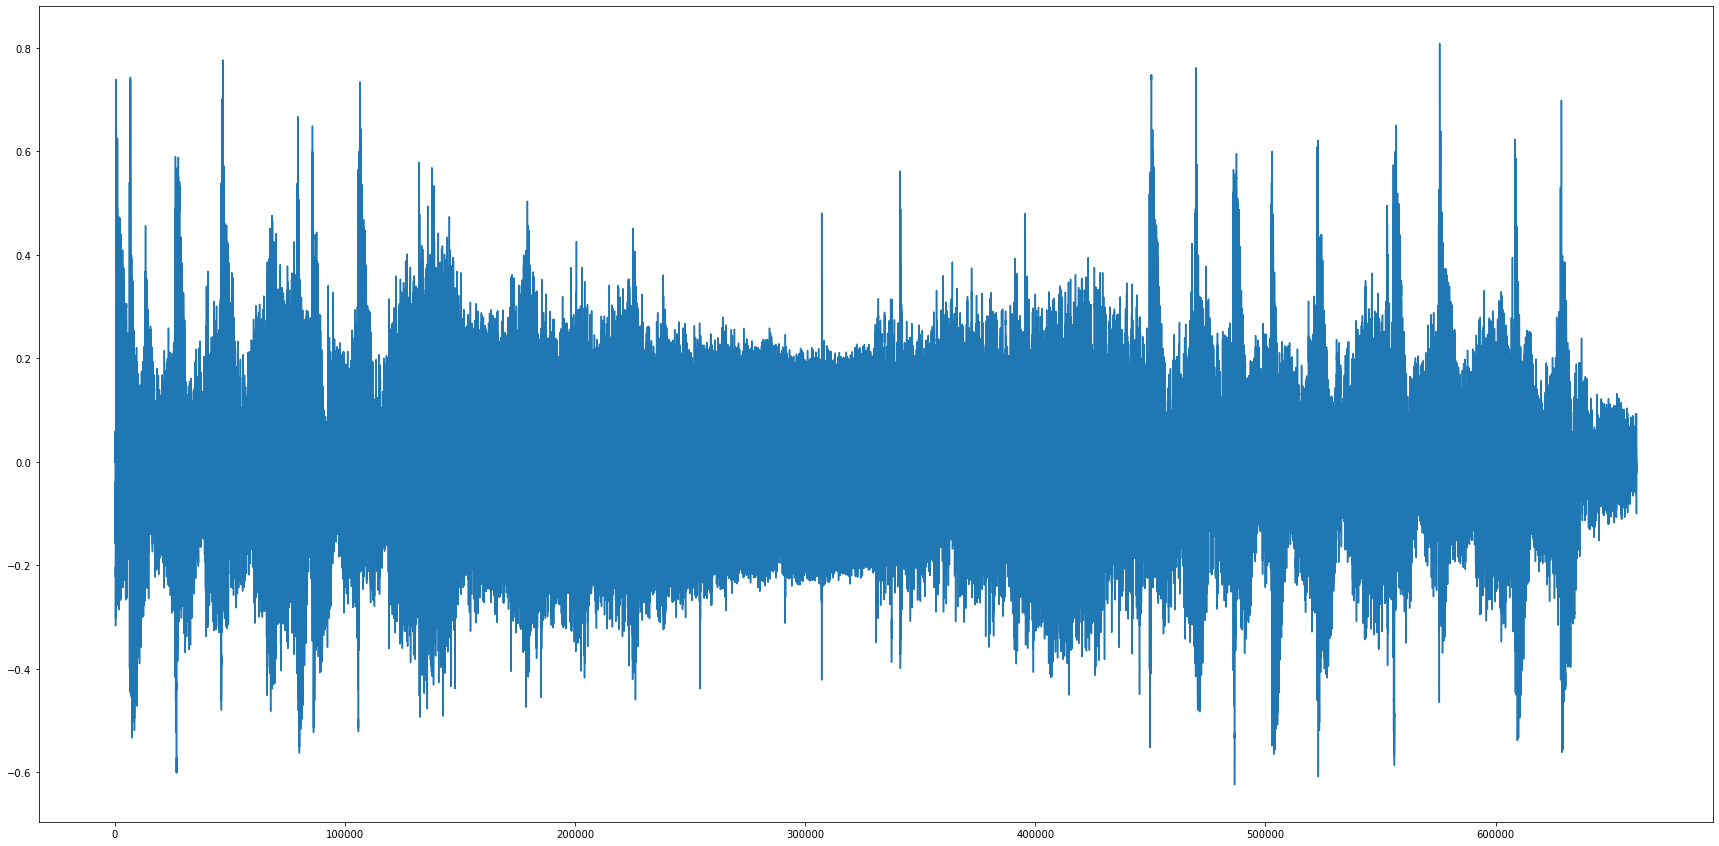

In [31]:
fig = plt.figure(figsize= (30, 15))
plt.plot(y)

In [27]:
mfccs = librosa.feature.mfcc(y)

In [49]:
mfccs[0]

array([-270.3988 , -245.5079 , -248.37785, ..., -272.64008, -278.76825,
       -215.09084], dtype=float32)

In [28]:
mfccs.shape

(20, 1292)

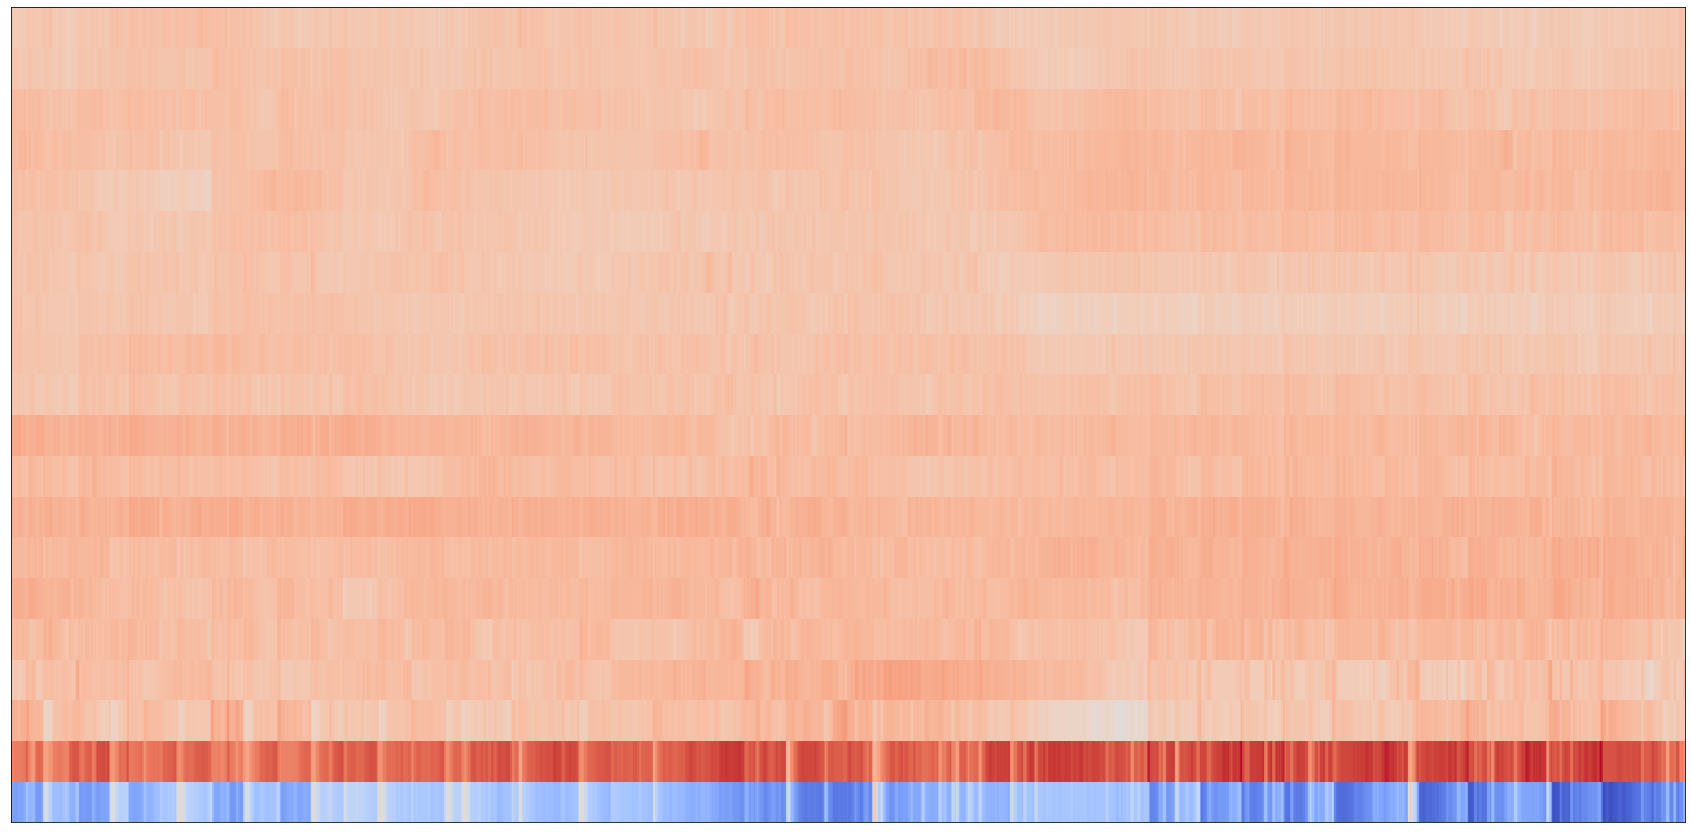

In [51]:
fig = plt.figure(figsize = (30, 15))
librosa.display.specshow(mfccs, cmap='coolwarm')